<a href="https://colab.research.google.com/github/mikaelasanchez/federated-learning-on-raspberry-pi/blob/master/Federated%20Recurrent%20Neural%20Network/FederatedLearningRaspberryPIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Install PySyft in Google Colab

!pip install tf-encrypted==0.5.6
!pip install msgpack==0.6.1

! URL="https://github.com/openmined/PySyft.git" && FOLDER="PySyft" && if [ ! -d $FOLDER ]; then git clone -b dev --single-branch $URL; else (cd $FOLDER && git pull $URL && cd ..); fi;

!cd PySyft; python setup.py install  > /dev/null

import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
!pip install --upgrade --force-reinstall lz4
!pip install --upgrade --force-reinstall websocket
!pip install --upgrade --force-reinstall websockets
!pip install --upgrade --force-reinstall zstd

From https://github.com/openmined/PySyft
 * branch              HEAD       -> FETCH_HEAD
Already up to date.
zip_safe flag not set; analyzing archive contents...
  Using cached https://files.pythonhosted.org/packages/0a/c6/96bbb3525a63ebc53ea700cc7d37ab9045542d33b4d262d0f0408ad9bbf2/lz4-2.1.10-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: lz4 2.1.10
    Uninstalling lz4-2.1.10:
      Successfully uninstalled lz4-2.1.10


  Using cached https://files.pythonhosted.org/packages/bf/45/142141aa47e01a5779f0fa5a53b81f8379ce8f2b1cd13df7d2f1d751ae42/greenlet-0.4.15-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f2/ca/5b5962361ed832847b6b2f9a2d0452c8c2f29a93baef850bb8ad067c7bf9/gevent-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: greenlet 0.4.15
    Uninstalling greenlet-0.4.15:
      Successfully uninstalled greenlet-0.4.15
  Found existing installation: gevent 1.4.0
    Uninstalling gevent-1.4.0:
      Successfully uninstalled gevent-1.4.0
  Found existing installation: websocket 0.2.1
    Uninstalling websocket-0.2.1:
      Successfully uninstalled websocket-0.2.1


  Using cached https://files.pythonhosted.org/packages/f0/4b/ad228451b1c071c5c52616b7d4298ebcfcac5ae8515ede959db19e4cd56d/websockets-8.0.2-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: websockets 8.0.2
    Uninstalling websockets-8.0.2:
      Successfully uninstalled websockets-8.0.2


  Found existing installation: zstd 1.4.1.0
    Uninstalling zstd-1.4.1.0:
      Successfully uninstalled zstd-1.4.1.0


In [0]:
from __future__ import unicode_literals, print_function, division
from torch.utils.data import Dataset

import torch
from io import open
import glob
import os
import numpy as np
import unicodedata
import string
import random
import torch.nn as nn
import time
import math
import syft as sy
import pandas as pd
import random
from syft.frameworks.torch.federated import utils

from syft.workers import WebsocketClientWorker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [0]:
!wget https://download.pytorch.org/tutorial/data.zip  

--2019-08-17 23:37:28--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.42.89, 13.226.42.64, 13.226.42.62, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.42.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.3’

data.zip.3          100%[===================>]   2.75M  6.11MB/s    in 0.5s    

2019-08-17 23:37:29 (6.11 MB/s) - ‘data.zip.3’ saved [2882130/2882130]



In [0]:
!unzip data.zip

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
path = '/content/data/names/*.txt'

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)


#Load files in the path
def findFiles(path):
  return glob.glob(path)

#Read a file and then split to lines
def readLines(filename):
  lines =open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

#Convert  string to ASCII format
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )



category_lines = {}
all_categories = []

for filename in findFiles(path):
  #print(filename)
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines
  
n_categories = len(all_categories)

#for names in glob.glob(path):
  #print(names)
  
 
print("Number of categories: " + "\n" + str(n_categories))
print("\n" + "All categories: ")
print(*all_categories, sep = "\n")

Number of categories: 
18

All categories: 
Italian
Irish
Dutch
Scottish
Vietnamese
Portuguese
Japanese
French
Chinese
Russian
Polish
German
Korean
Greek
English
Arabic
Czech
Spanish


In [0]:
print(*category_lines['Polish'][:6], sep = "\n")

Adamczak
Adamczyk
Andrysiak
Auttenberg
Bartosz
Bernard


In [0]:
class LanguageDataset(Dataset):
  # Constructor
  def __init__(self, text, labels, transform=None):
    self.data = text
    self.targets = labels # categories
    #self.to_torchtensor()
    self.transform = transform
    
  def to_torchtensor(self):
    self.data = torch.from_numpy(self.text, requires_grad=True)
    self.labels = torch.from_numpy(self.targets, requires_grad=True)
  
  # Returns length of dataset/batches
  def __len__(self):
    return len(self.data)
  
  # Returns data and target[torch tensor ]
  def __getitem__(self, idx):
    sample = self.data[idx]
    target = self.targets[idx]
    
    if self.transform:
      sample = self.transform(sample)
      
    return sample, target
    
  

In [0]:
# Arguments for the program
class Arguments():
  def __init__(self):
    self.batch_size = 1
    self.learning_rate = 0.005
    self.epochs = 10000
    self.federate_after_n_batches =15000
    self.seed = 1
    self.print_every = 200
    self.plot_every = 100
    self.use_cuda = False
    
args = Arguments()
    

In [0]:
%%latex

\begin{split}
names\_list = [d_1,...d_n]  \\

category\_list = [c_1,...c_n]
\end{split}

<IPython.core.display.Latex object>

In [0]:
names_list = []
category_list = []

for nation, names in category_lines.items():
  for name in names:
    names_list.append(name)
    category_list.append(nation)
    
print(*names_list[:5], sep = "\n")
print(*category_list[:5], sep = "\n")
print("\n")
print("Data points loaded: " + str(len(names_list)))



Abandonato
Abatangelo
Abatantuono
Abate
Abategiovanni
Italian
Italian
Italian
Italian
Italian


Data points loaded: 20074


In [0]:
# An integer to every category
categories_numerical = pd.factorize(category_list)[0]

# Categories with tensor
category_tensor = torch.tensor(np.array(categories_numerical), dtype=torch.long)

categories_numpy = np.array(category_tensor)

print(names_list[100:120])
print(categories_numpy[100:120])


['Allegro', 'Alo', 'Aloia', 'Aloisi', 'Altamura', 'Altimari', 'Altoviti', 'Alunni', 'Amadei', 'Amadori', 'Amalberti', 'Amantea', 'Amato', 'Amatore', 'Ambrogi', 'Ambrosi', 'Amello', 'Amerighi', 'Amoretto', 'Angioli']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We will turn every character in each input string into a vector, with a 1 marking that particular character present. <br>
A word will just be a vector of character vectors and our RNN will process every character vector in the word.<br>
This technique is called word embedding.

In [0]:
# This returns the index of a letter given
def letterToIndex(letter):
    return all_letters.find(letter)
    

# Turn a line into a <line_length x 1 x n_letters>
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor    
    
    
# Turn a list of strings into a list of tensors
def list_strings_to_list_tensors(names_list):
    lines_tensors = []
    for index, line in enumerate(names_list):
        lineTensor = lineToTensor(line)
        lineNumpy = lineTensor.numpy()
        lines_tensors.append(lineNumpy)
        
    return(lines_tensors)

lines_tensors = list_strings_to_list_tensors(names_list)

In [0]:
# Testing the functions work
print(names_list[0])
print(lines_tensors[0])
print(lines_tensors[0].shape)

Abandonato
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.

In [0]:
# Identify the longest word in the dataset as all tensors need to have the same
# shape 

max_line_size = max(len(x) for x in lines_tensors)

# Turn a line into a <line_length x 1 x n_letters>
def lineToTensorFillEmpty(line, max_line_size):
    tensor = torch.zeros(max_line_size, 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
        
    # If there is no character, a vector with (0,0,.... ,0) will be placed
    return tensor

# Turn a list of strings into a list of tensors using previous function
def list_strings_to_list_tensors_fill_empty(names_list):
    lines_tensors = []
    for index, line in enumerate(names_list):
        lineTensor = lineToTensorFillEmpty(line, max_line_size)
        lines_tensors.append(lineTensor)
    return(lines_tensors)

lines_tensors = list_strings_to_list_tensors_fill_empty(names_list)

In [0]:
# Tensor shape check
print(lines_tensors[0].shape)

torch.Size([19, 1, 56])


In [0]:
# Create numpy array with all word embeddings
array_lines_tensors = np.stack(lines_tensors)
array_lines_proper_dimension = np.squeeze(array_lines_tensors, axis=2)

# Check array dimension
print(array_lines_proper_dimension.shape)

(20074, 19, 56)


In [0]:
def find_start_index_per_category(category_list):
    categories_start_index = {}
    
    #Initialize every category with an empty list
    for category in all_categories:
        categories_start_index[category] = []
    
    #Insert the start index of each category into the dictionary categories_start_index
    #Example: "Italian" --> 203
    #         "Spanish" --> 19776
    last_category = None
    i = 0
    for name in names_list:
        cur_category = category_list[i]
        if(cur_category != last_category):
            categories_start_index[cur_category] = i
            last_category = cur_category
        
        i = i + 1
        
    return(categories_start_index)

categories_start_index = find_start_index_per_category(category_list)

print(categories_start_index)

{'Italian': 0, 'Irish': 709, 'Dutch': 941, 'Scottish': 1238, 'Vietnamese': 1338, 'Portuguese': 1411, 'Japanese': 1485, 'French': 2476, 'Chinese': 2753, 'Russian': 3021, 'Polish': 12429, 'German': 12568, 'Korean': 13292, 'Greek': 13386, 'English': 13589, 'Arabic': 17257, 'Czech': 19257, 'Spanish': 19776}


In [0]:
def randomChoice(l):
    rand_value = random.randint(0, len(l) - 1)
    return l[rand_value], rand_value


def randomTrainingIndex():
    category, rand_cat_index = randomChoice(all_categories) #cat = category, it's not a random animal
    #rand_line_index is a relative index for a data point within the random category rand_cat_index
    line, rand_line_index = randomChoice(category_lines[category])
    category_start_index = categories_start_index[category]
    absolute_index = category_start_index + rand_line_index
    return(absolute_index)

In [0]:
#Two hidden layers, based on simple linear layers

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#Let's instantiate the neural network already:
n_hidden = 128
#Instantiate RNN

device = torch.device("cuda" if args.use_cuda else "cpu")
model = RNN(n_letters, n_hidden, n_categories).to(device)
#The final softmax layer will produce a probability for each one of our 18 categories
print(model)

RNN(
  (i2h): Linear(in_features=184, out_features=128, bias=True)
  (i2o): Linear(in_features=184, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


In [0]:
# Specify remote workers's location

hook = sy.TorchHook(torch)  # Hook PyTorch

# Uncomment this with the ip of each raspberry pi worker if you're using the
# raspberry pi and comment the block of code beneath this

# kwargs_websocket_alice = {"host": "ip_alice", "hook": hook}
# alice = WebsocketClientWorker(id="alice", port=8777, **kwargs_websocket_alice)
# kwargs_websocket_bob = {"host": "ip_bob", "hook": hook}
# bob = WebsocketClientWorker(id="bob", port=8778, **kwargs_websocket_bob)

alice = sy.VirtualWorker(hook, id="alice")  
bob = sy.VirtualWorker(hook, id="bob")  

workers_virtual = [alice, bob]

W0817 23:37:51.728178 140317129680768 hook.py:100] Torch was already hooked... skipping hooking process


In [0]:
# array_lines_proper_dimension = our data points(X)
# categories_numpy = our labels (Y)
langDataset = LanguageDataset(array_lines_proper_dimension, categories_numpy)

#assign the data points and the corresponding categories to workers.
federated_train_loader = sy.FederatedDataLoader(
    langDataset.federate(workers_virtual),
    batch_size=args.batch_size)

# Model Training
Now the data is processed, we'll start to train our RNN!

In [0]:
# Gives the category that corresponds to maximum predicted class probability
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# Gives the amount of time passed since "since"
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Federated averaging
def fed_avg_every_n_iters(model_pointers, iter, federate_after_n_batches):
        models_local = {}
        
        if(iter % args.federate_after_n_batches == 0):
            for worker_name, model_pointer in model_pointers.items():
                # Assign model to the worker
                models_local[worker_name] = model_pointer.copy().get()
            model_avg = utils.federated_avg(models_local)
           
            for worker in workers_virtual:
                model_copied_avg = model_avg.copy()
                model_ptr = model_copied_avg.send(worker) 
                model_pointers[worker.id] = model_ptr
                
        return(model_pointers)     

def fw_bw_pass_model(model_pointers, line_single, category_single):
  
    # Get the right initialized model
    model_ptr = model_pointers[line_single.location.id]   
    line_reshaped = line_single.reshape(max_line_size, 1, len(all_letters))
    line_reshaped, category_single = line_reshaped.to(device), category_single.to(device)
    
    # Initialize hidden layer
    hidden_init = model_ptr.initHidden() 
    
    # And now zero the gradient
    model_ptr.zero_grad()
    hidden_ptr = hidden_init.send(line_single.location)
    amount_lines_non_zero = len(torch.nonzero(line_reshaped.copy().get()))
    
    # Forward passes
    for i in range(amount_lines_non_zero): 
        output, hidden_ptr = model_ptr(line_reshaped[i], hidden_ptr) 
    criterion = nn.NLLLoss()   
    loss = criterion(output, category_single) 
    loss.backward()
    
    model_got = model_ptr.get() 
    
    # Update model's weights 
    for param in model_got.parameters():
        param.data.add_(-args.learning_rate, param.grad.data)
        
        
    # Send the model
    model_sent = model_got.send(line_single.location.id)
    model_pointers[line_single.location.id] = model_sent
    
    return(model_pointers, loss, output)


In [0]:
# Training function
def train_RNN(n_iters, print_every, plot_every, federate_after_n_batches, list_federated_train_loader):
    current_loss = 0
    all_losses = []    
    
    model_pointers = {}
    
    # Send the initialized model to every single worker just before training
    for worker in workers_virtual:
        model_copied = model.copy()
        model_ptr = model_copied.send(worker) 
        model_pointers[worker.id] = model_ptr

    # Extract a random element from the list and perform training on it
    for iter in range(1, n_iters + 1):        
        random_index = randomTrainingIndex()
        line_single, category_single = list_federated_train_loader[random_index]
        line_name = names_list[random_index]
        model_pointers, loss, output = fw_bw_pass_model(model_pointers, line_single, category_single)
        
        # Update theloss
        loss_got = loss.get().item() 
        current_loss += loss_got
        
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
             
        # Print information on training
        # The name, guessed category, correct/incorrect and actual category
        if(iter % print_every == 0):
            output_got = output.get()
            guess, guess_i = categoryFromOutput(output_got)
            category = all_categories[category_single.copy().get().item()]
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, 
                                                    timeSince(start), 
                                                    loss_got, 
                                                    line_name, guess, correct))
            
            
    return(all_losses, model_pointers)

## Start the training

In [0]:
# Turn the data points and categories into a list
list_federated_train_loader = list(federated_train_loader)

# Start the training
start = time.time()
all_losses, model_pointers = train_RNN(args.epochs, args.print_every, 
                                       args.plot_every, 
                                       args.federate_after_n_batches, 
                                       list_federated_train_loader)

200 2% (0m 4s) 2.6959 Lillis / Greek ✓
400 4% (0m 9s) 2.8750 Salomon / Spanish ✗ (Polish)
600 6% (0m 13s) 2.7425 Michel / Italian ✗ (French)
800 8% (0m 18s) 2.5838 Walter / English ✓
1000 10% (0m 22s) 2.5549 Svocak / Spanish ✗ (Czech)
1200 12% (0m 27s) 2.3157 Gouveia / Italian ✗ (Portuguese)
1400 14% (0m 31s) 2.1592 Sergeant / Dutch ✗ (French)
1600 16% (0m 36s) 2.5582 Alvarez / Polish ✗ (Spanish)
1800 18% (0m 40s) 2.5616 Han / Scottish ✗ (Chinese)
2000 20% (0m 45s) 2.2302 Mingo / English ✗ (Spanish)
2200 22% (0m 50s) 1.2334 Hagias / Greek ✓
2400 24% (0m 54s) 2.7290 Salazar / German ✗ (Spanish)
2600 26% (0m 59s) 2.1957 Voltolini / French ✗ (Italian)
2800 28% (1m 4s) 2.6820 Awdeeff / Irish ✗ (Russian)
3000 30% (1m 8s) 2.3098 Sioda / Portuguese ✗ (Irish)
3200 32% (1m 13s) 1.8625 Banos / Greek ✓
3400 34% (1m 17s) 2.4356 Sinclair / Russian ✗ (Scottish)
3600 36% (1m 22s) 1.7367 Ferguson / Scottish ✓
3800 38% (1m 27s) 0.6339 Sklavenitis / Greek ✓
4000 40% (1m 31s) 1.8415 Sook / Arabic ✗ (Kore

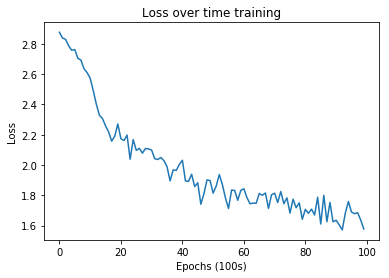

In [0]:
# Plot the loss we got during the training procedure
plt.figure()
plt.title("Loss over time training")
plt.ylabel("Loss")
plt.xlabel('Epochs (100s)')
plt.plot(all_losses)